# 디렉토리 설정 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/CT분류프로젝트/Custom_Py/init.py' ./

In [ ]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

# 초기작업

## 기본 DF 생성 

In [5]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression
)

###snsb_df 생성 

In [6]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x))) #소수점으로 되어 있는 것 처리하고 str형 변형 

snsb_df = snsb_df[columns]

###dir_df 생성 

In [7]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['key','dir'])
dir_df = dir_df.reset_index().drop(columns = 'index')

### 병록번호- key 값 보정
- 자리수 다 다른거, 중복인거 보정 
- 9자리로 통일 

In [8]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

dir_df,snsb_df = init.key_mismatch(dir_df,snsb_df,target_length)
#인덱스 초기화 
dir_df = dir_df.reset_index().drop(columns = 'index')
# plt.hist(snsb_df['병록번호'].map(len))
# plt.show()

#에러값들 제외 
errors = ['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']

dir_df = dir_df.drop(np.where(dir_df['key'].map(len)>9)[0])

## new_dir_df 생성 - 이미지 장수 통일 


### key 값 별 이미지 장수 연산 

In [9]:
#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: init.check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
# images_length.value_counts()

length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
# length_df_less = length_df[length_df['image_length']<standard]

len(length_df_over)

1606

### key값 별로 이미지 19장 있는 new_dir_df 생성 

In [10]:
new_dir_df = pd.DataFrame(np.zeros(len(length_df_over)*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

for index in tqdm(range(len(length_df_over))):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

100%|██████████| 1606/1606 [00:08<00:00, 186.66it/s]


## csvs 생성 - z 스코어 임베딩 + 중복제거 



In [11]:
#19장의 사진으로 추린 new_dir_df로 새로운 키 리스트만듬) 

key_lists = np.unique(new_dir_df['key'])
key_lists.sort()

Embedding_columns = snsb_df.columns[5:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key','dir'])

#snsb_df 중 key_lists에 있는 행들만 추림 -> csvs 
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')

#중복 제거 : 이름으로 정렬 후 중복 제거 
csvs = csvs.sort_values(by=['성명'])
csvs = csvs.drop_duplicates(['병록번호'], keep = 'first')

#다시 병록번호 로 정렬 해서 csvs 와 new_dir_df 순을 맞춤 
csvs = csvs.sort_values(['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

#맞춤 확인 
print(len(csvs),len(np.unique(new_dir_df['key'])))

1606 1606


# 전처리

## new_dir_df 증강 

In [12]:
new_dir_df['dir_1'] = 0
new_dir_df['dir_2'] = 0 
new_dir_df['dir_1'].iloc[:-1] = new_dir_df['dir'].iloc[1:]
new_dir_df['dir_2'].iloc[:-2] = new_dir_df['dir'].iloc[2:]

In [13]:
i = 0 
drop_indexes = [] 
for i in range(len(key_lists)):
  drop_index = new_dir_df[new_dir_df['key']==key_lists[i]].iloc[17:20,].index
  drop_indexes.append(drop_index)
drop_indexes = np.array(drop_indexes).reshape(-1,)
new_dir_df.drop(drop_indexes,inplace=True)
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

## csvs 증강 

In [14]:
temp_csvs = np.array(csvs)
for i in tqdm(range(16)):
  temp_csvs = np.vstack([temp_csvs,np.array(csvs)])
temp_csvs = pd.DataFrame(temp_csvs)
temp_csvs.columns = csvs.columns
csvs = temp_csvs.sort_values(by=['병록번호']).reset_index().drop(columns = 'index')

100%|██████████| 16/16 [00:00<00:00, 228.73it/s]


## Augmentation 

In [21]:
#이미지 콘트라스트 변경 
def img_Contrast(img): 
  import cv2 
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)) 
  cl = clahe.apply(l)
  limg = cv2.merge((cl, a, b))
  final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  return final 
#가우시안 블러 
def gaussianblur(image):
  import cv2 
  import numpy as np 
  blur = cv2.GaussianBlur(image, (5,5), np.random.randint(0,3,1))
  return blur

import albumentations as A
transform = A.Compose([
    RandomBrightness(limit=0.1),
    JpegCompression(quality_lower=85, 
                    quality_upper=100, p=0.5), 
    HueSaturationValue(hue_shift_limit=20,
                        sat_shift_limit=30, 
                    val_shift_limit=20, p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])


#랜덤 어그먼테이션 
def random_aug(aug_image):
  import numpy as np 
  import cv2 
  n = np.random.randint(0,4,1)
  if n == 0:
    aug_image = cv2.flip(aug_image,np.random.randint(0,2,1))
  if n == 1:
    try: 
      aug_image = transforms(aug_image)
    except:
      pass
  if n ==2:
    aug_image = gaussianblur(aug_image)
  if n ==3:
    pass
  return aug_image


## 이미지 전처리

In [16]:
def plot_img(temp_img):
  plt.figure(figsize=(10,10))
  plt.imshow(temp_img)
  plt.show()

In [22]:
#이미지 전처리 

def img_preprocess(img):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  preprocessed_img = transform(image=preprocessed_img)['image']
  preprocessed_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2GRAY)
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(224,224)) #resize Albu mentations -> vision 관련 augmentation document 
  preprocessed_img = preprocessed_img/255.
  # preprocessed_img = efficientnet.preprocess_input(preprocessed_img) 
  return preprocessed_img 


#더미 넘파이 만든 후 거기다 224,224 grayscale 이미지 넣음
#디렉토리 df로 이미지 만듬 
def read_imgs(indexed_df):
    temp_img_1 = img_preprocess(cv2.imread(indexed_df['dir']))
    temp_img_2 = img_preprocess(cv2.imread(indexed_df['dir_1']))
    temp_img_3 = img_preprocess(cv2.imread(indexed_df['dir_2']))
    temp_imgs = np.stack([temp_img_1,temp_img_2,temp_img_3],axis=2)
    return temp_imgs

# 데이터 제너레이터

## 사전설정

In [23]:
input_columns = ['만나이','교육년수']
output_columns = ['E_SVLT_recall_total_score_z', 'E_SVLT_Delayed_recall_z',
       'E_SVLT_recognition_score_z', 'E_RCFT_immediate_recall_z',
       'E_RCFT_delayed_recall_z', 'E_RCFT_recognition_score_z',
       'E_K_MMSE_total_score_z', 'E_SNSB_II_Domain_Attention_z',
       'E_SNSB_II_Domain_Language_z', 'E_SNSB_II_Domain_Visuospatial_z',
       'E_SNSB_II_Domain_Memory_z', 'E_SNSB_II_Domain_Frontal_z']

csvs_max = np.array([90,18])
csvs_min = np.array([45,0])

## 제너레이터

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 new_dir_df,
                 csvs,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.output_columns = output_columns
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.rescale =rescale
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return math.ceil(len(self.new_dir_df) / self.batch_size)
    
  def on_epoch_end(self):
    self.indices = np.arange(len(self.new_dir_df))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.new_dir_df = self.new_dir_df.iloc[self.indices]
      self.csvs = self.csvs.iloc[self.indices]



  def __getitem__(self, index):
    csvs_input = self.csvs[self.input_columns].iloc[index*self.batch_size:(index+1)*self.batch_size,:]
    csvs_output = self.csvs[self.output_columns].iloc[index*self.batch_size : (index+1)*self.batch_size,:]
    imgs_dir_df = self.new_dir_df[index*self.batch_size : (index+1)*self.batch_size]

    imgs = []
    for i in range(len(imgs_dir_df)):
      indexed_df = imgs_dir_df.iloc[i,:]
      temp_imgs = read_imgs(indexed_df)
      imgs.append(temp_imgs)
    imgs = np.array(imgs)

    csvs_input = np.array(csvs_input).astype(np.float)
    csvs_input = (csvs_input - csvs_min)/(csvs_max - csvs_min)
    csvs_output = np.array(csvs_output).astype(np.float)
    imgs=  np.array(imgs).astype(np.float)
    
    # return [imgs, csvs_input], csvs_output
    # return [imgs,csvs_input], [np.array(csvs_output[:,0]),np.array(csvs_output[:,1]),np.array(csvs_output[:,2]),np.array(csvs_output[:,3]),
    #               np.array(csvs_output[:,4]),np.array(csvs_output[:,5]),np.array(csvs_output[:,6]),np.array(csvs_output[:,7]),
    #               np.array(csvs_output[:,8]),np.array(csvs_output[:,9]),np.array(csvs_output[:,10]),np.array(csvs_output[:,11])]
    
    return [imgs,csvs_input], np.array(csvs_output[:,0])

# train = 964*17
# valid = 1285*17
train = 160*17
valid = 200*17
train_generator = DataGenerator(new_dir_df[:train],csvs[:train],batch_size=32,shuffle=True)
valid_generator = DataGenerator(new_dir_df[train:valid],csvs[train:valid],batch_size=32,shuffle=False)
test_generator = DataGenerator(new_dir_df[valid:],csvs[valid:],batch_size=16)

In [28]:
train_generator.on_epoch_end()
a,b = next(iter(train_generator))

train : 964*17

valid : [964~1285]*17

test : [1285~1606]*17 

약 60:20:20

#모델

In [42]:
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Activation, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Dense,Flatten,Input,Conv3D,MaxPooling3D
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet169, MobileNet

## 모델 사전 세팅

In [38]:
def output(x):
  output_2 = Dense(16,activation = 'relu')(x)
  output_2 = BatchNormalization()(output_2)
  output_2 = Dense(8,activation = 'relu')(output_2)
  output_2 = BatchNormalization()(output_2) 
  output_2 = Dense(2, activation = 'softmax')(output_2)
  return output_2

conv_layers1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3)) #size -> 256, 256 
conv_layers1.trainable = False

# conv_layers2 = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224,3)) #size -> 256, 256 
# conv_layers2.trainable = False

# conv_layers3 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224,3)) #size -> 256, 256 
# conv_layers3.trainable = False

adam = Adam(learning_rate = 0.0005)

In [40]:
def conv_layers(conv_layer,image_input):
  conv = conv_layer(image_input)

  # conv = Conv2D(256,kernel_size=3, activation = 'relu',padding='same')(conv)
  # conv = Dropout(0.25)(conv)
  # conv = BatchNormalization()(conv)

  # conv = Conv2D(128,kernel_size=3, activation = 'relu',padding='same')(conv)
  # conv = Dropout(0.25)(conv)
  # conv = BatchNormalization()(conv)

  # conv = Conv2D(64,kernel_size=3, activation = 'relu',padding='same')(conv)
  # conv = Dropout(0.25)(conv)
  # conv = BatchNormalization()(conv)

  # conv = Conv2D(32,kernel_size=3, activation = 'relu',padding='same')(conv)
  # conv = Dropout(0.25)(conv)
  # conv = BatchNormalization()(conv)

  # conv = Conv2D(16,kernel_size=3, activation = 'relu',padding='same')(conv)
  # conv = AveragePooling2D()(conv)
  # conv = Dropout(0.25)(conv)
  conv_out = BatchNormalization()(conv)

  return conv_out

In [49]:
from tensorflow.python import keras
def make_model():
  image_input = Input((224,224,3))

  conv_1 = conv_layers(conv_layers1,image_input)
  # conv_2 = conv_layers(conv_layers2,image_input)
  # conv_3 = conv_layers(conv_layers3,image_input)


  # image_combined = concatenate([conv_1,conv_2,conv_3])
  image = Conv2D(256,kernel_size=3, activation = 'relu',padding='same')(conv_1)
  image = MaxPooling2D()(image)
  image = Conv2D(32,(3,3))(image)
  image = GlobalAveragePooling2D()(image)
  image_output = Dropout(0.2)(image)
  

  csvs_input = Input((2))
  csvs = Dense(16,activation = 'relu')(csvs_input)
  csvs_out = Dropout(0.25)(csvs)
 

  combined = concatenate([image_output,csvs_out])
  output_1 = Dense(2, activation = 'softmax')(combined)
  
  
 #output이 너무 많다 
  # output_1 = output(x)
  # output_2 = output(x)
  # output_3 = output(x)
  # output_4 = output(x)
  # output_5 = output(x)
  # output_6 = output(x)
  # output_7 = output(x)
  # output_8 = output(x)
  # output_9 = output(x)
  # output_10 = output(x)
  # output_11 = output(x)
  # output_12 = output(x)

  model = Model([image_input,csvs_input],[output_1])
  model.compile(optimizer=adam,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
  return model
model = make_model()

In [ ]:
model.summary()

## 학습 

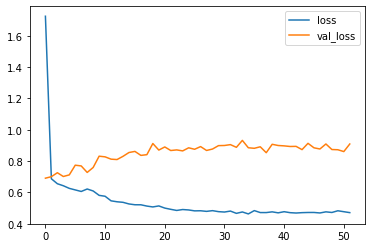

loss =  0.470797598361969 , val_loss =  0.9091343879699707
170/170 [==============================] - 158s 928ms/step - loss: 0.4708 - accuracy: 0.7636 - val_loss: 0.9091 - val_accuracy: 0.4926 - lr: 1.6000e-07
Epoch 53/100
 16/170 [=>............................] - ETA: 1:56 - loss: 0.4371 - accuracy: 0.8242

In [ ]:
#224,224,3 + 모델 축소 + lr
history = model.fit(train_generator,validation_data = valid_generator, epochs=100,verbose=1,callbacks=callbacks)

## 콜백

In [34]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses,reduce_lr]

#예측 및 평가 -> voting 

In [ ]:
y_ = model.predict(test_generator)
for i in range(12):
  exec(f'predicted_{i} = np.argmax(y_[{i}],axis=1)')

target_0 = np.array(csvs[output_columns][valid:])[:,0]

temp = pd.DataFrame([predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,predicted_9,predicted_10,predicted_11]).T
temp['index']=0

for i in range(321):
  temp['index'].iloc[i*17:(i+1)*17] = i 

In [ ]:
temp[temp['index']==0]

In [ ]:
np.round(np.mean(np.array(temp[temp['index']==0]),axis=0))[:-1]

array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])

In [ ]:
predicted_y = pd.DataFrame(np.zeros(321*12).reshape(321,12))

for i in range(321):
  predicted_y.iloc[i,:] = np.round(np.mean(np.array(temp[temp['index']==i]),axis=0))[:-1]

test_y = csvs[valid:]
test_y = test_y.reset_index().drop(columns = 'index')
test_y.drop_duplicates(['성명'],keep='first')
test_y = np.array(test_y[output_columns])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report,accuracy_score

In [ ]:
print(classification_report(test_y,np.array(predicted_y),target_names = ['0','1','2','3','4','5','6','7','8','9','10','11']))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60       174
           1       0.54      0.35      0.42       130
           2       0.59      0.22      0.32       169
           3       0.57      0.55      0.56       164
           4       0.58      0.42      0.49       154
           5       0.58      0.54      0.56       158
           6       0.63      0.17      0.26       133
           7       0.74      0.86      0.80       235
           8       0.66      0.59      0.63       190
           9       0.61      0.62      0.61       165
          10       0.67      0.06      0.12       124
          11       0.71      0.32      0.44       111

   micro avg       0.64      0.47      0.54      1907
   macro avg       0.63      0.44      0.48      1907
weighted avg       0.63      0.47      0.51      1907
 samples avg       0.61      0.48      0.47      1907



In [ ]:
score = precision_recall_fscore_support(test_y,np.array(predicted_y))
score = pd.DataFrame([score[0],score[1],score[2]])
score.index = ['precision','recall','f1score']
score['average']=0
for i in range(3):
  score['average'].iloc[i] = np.mean(np.array(score)[i,:])
score

,0,1,2,3,4,5,6,7,8,9,10,11,average
precision,0.686567,0.535714,0.587302,0.573248,0.580357,0.582192,0.628571,0.743590,0.660819,0.605882,0.666667,0.705882,0.581292
recall,0.528736,0.346154,0.218935,0.548780,0.422078,0.537975,0.165414,0.863830,0.594737,0.624242,0.064516,0.324324,0.403055
f1score,0.597403,0.420561,0.318966,0.560748,0.488722,0.559211,0.261905,0.799213,0.626039,0.614925,0.117647,0.444444,0.446906


In [ ]:
acc = accuracy_score(test_y.reshape(321*12,),np.array(predicted_y).reshape(-1,))
print(f'accuracy = {acc}')

accuracy = 0.6061786085150571
